In [1]:
import random
from colorutils import Color
from configs import CFG1
from generators import create_image

In [2]:
from pathlib import Path
import pandas as pd

messages = pd.read_csv("texts/messages.csv")
options = pd.read_csv("texts/options.csv")
names = pd.read_csv("texts/names.csv")

bgimage_paths = list(Path("bgimages").rglob(pattern="*.png"))
fgimage_paths = list(Path("fgimages").rglob(pattern="*.png"))
messages.shape, options.shape, names.shape, len(bgimage_paths), len(fgimage_paths)

((15762, 5), (36218, 3), (6480, 3), 976, 354)

In [3]:
def generate():
    cfg = CFG1()

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.text = text_ruby_hira
    
    # 名前
    if random.random() < 0.5:
        name_text, name_ruby = names.sample(1)[["name", "ruby"]].values[0]
        if type(name_ruby) == str:
            name_text = f"<ruby>{name_text}<rt>{name_ruby}</rt></ruby>"
        cfg.name_text = name_text

    # 選択肢
    n_options = random.choice([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    if n_options == 1:
        cfg.optionbox_tl = (230, (250+435)//2)
        cfg.optionbox_br = (1680, (385+570)//2)
    option_texts = []
    for i in range(n_options):
        option_texts.append(options.sample(1)["text_ruby_hiragana"].values[0])
    cfg.option_texts = option_texts

    # 背景画像
    bg_path = random.choice(bgimage_paths)
    cfg.bg_path = bg_path

    # 人物などの画像
    n_fg_images = random.choice([0, 1, 2])
    if n_fg_images == 1:
        cfg.fg_tl_list = [(500, 100)]
    elif n_fg_images == 2:
        cfg.fg_tl_list = [(200, 100), (1000, 100)]

    cfg.fg_pathlist = random.sample(fgimage_paths, n_fg_images)

    output = create_image(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "meta":{"version":"0.1.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

In [25]:
import json
import datasets
from datasets import Dataset
images, gts = [], []
for i in range(1, 11):
    image, gt = generate()
    output_image_path = f"output_images/{i:05d}.png"
    image.save(output_image_path)
    images.append(output_image_path)
    gts.append(gt)
    # if len(images) == 20:
    #     df = pd.DataFrame([[img, json.dumps(gt, ensure_ascii=False)] for img, gt in zip(images, gts)], columns=["image", "ground_truth"])
    #     ds = Dataset.from_pandas(df)
    #     ds = ds.cast_column("image", datasets.Image())
    #     ds.save_to_disk(f"output_datasets/dataset_{i}")
    #     images, gts = [], []

In [20]:
dss = []
for i in range(200, 2001, 200):
    dss.append(datasets.load_from_disk(f"output_datasets/dataset_{i}"))
ds = datasets.concatenate_datasets(dss)
ds.save_to_disk("output_datasets/dataset")

Saving the dataset (0/9 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
ds = Dataset.load_from_disk(f"output_datasets/dataset")
ds

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 2000
})

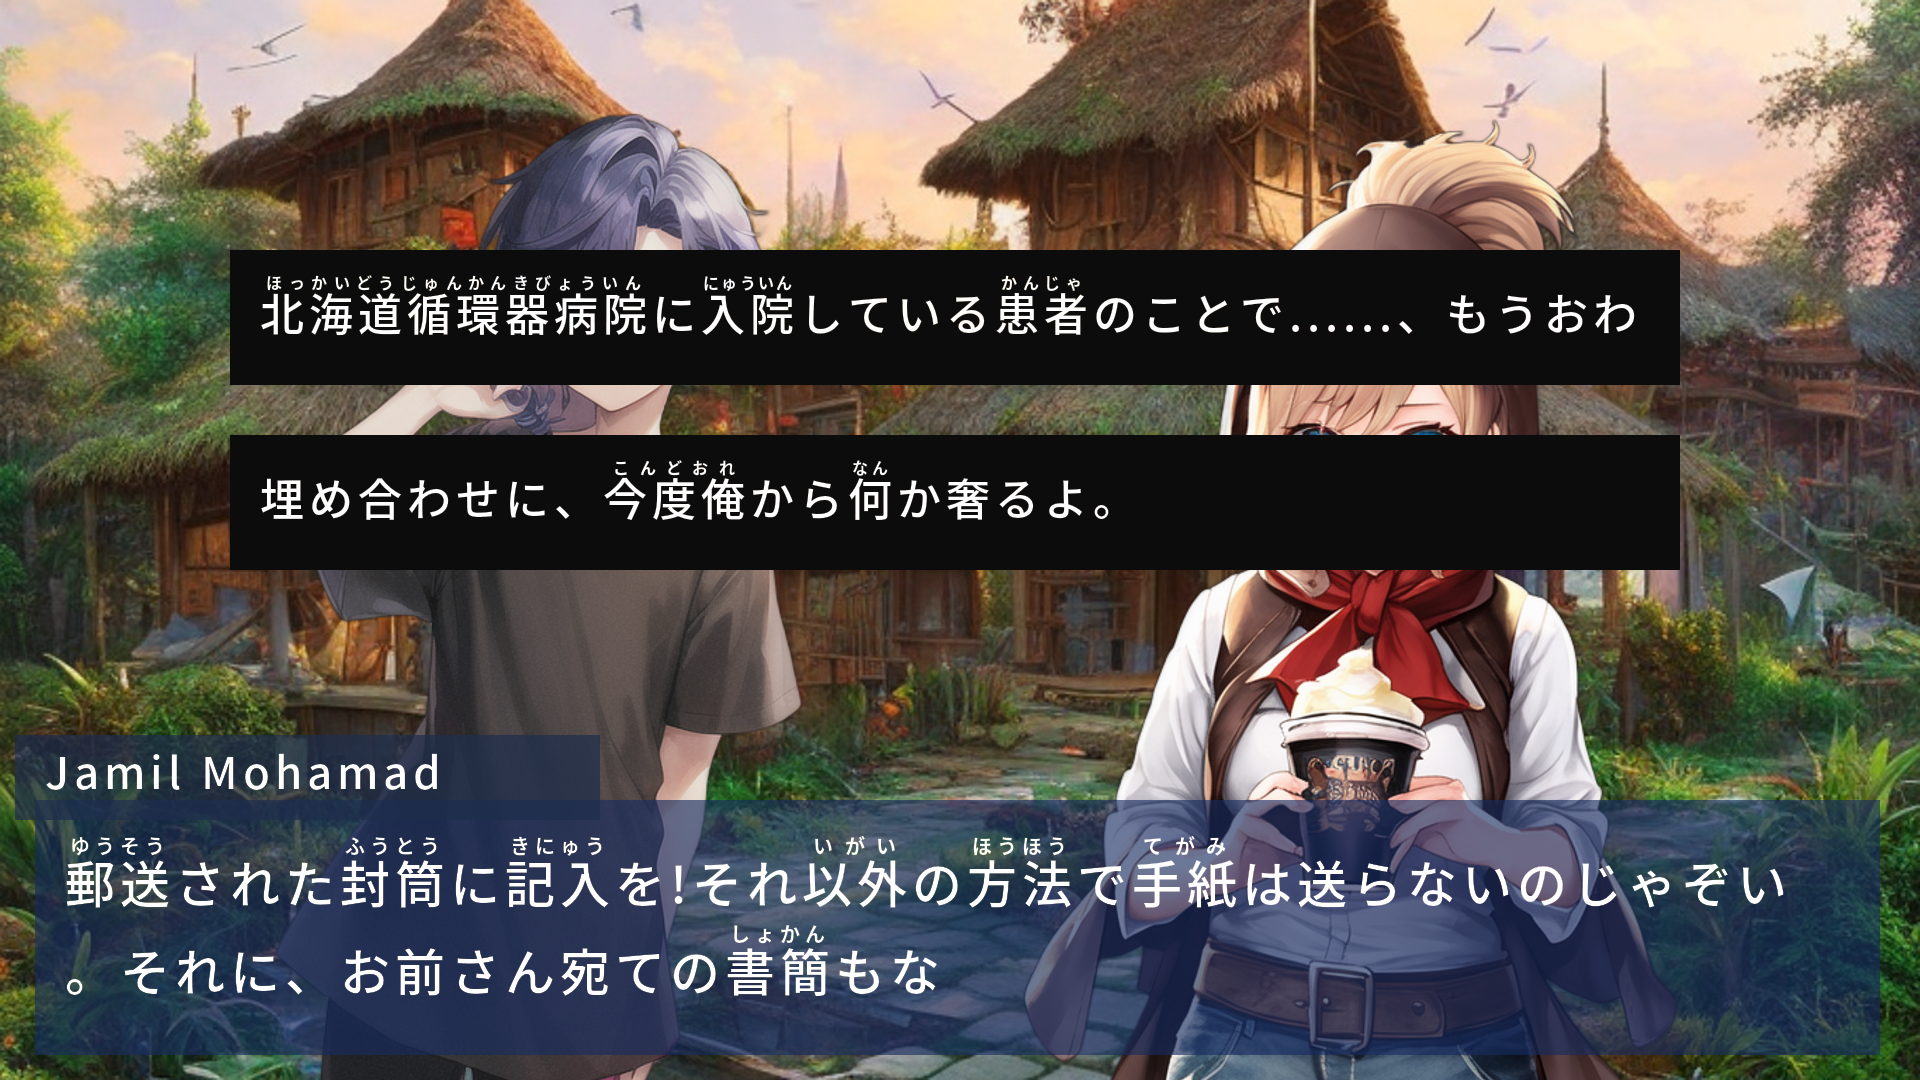

In [22]:
ds[1992]["image"]

In [23]:
json.loads(ds[1992]["ground_truth"])

{'gt_parse': {'messages': ['<ruby>郵送<rt>ゆうそう</rt></ruby>された<ruby>封筒<rt>ふうとう</rt></ruby>に<ruby>記入<rt>きにゅう</rt></ruby>を!それ<ruby>以外<rt>いがい</rt></ruby>の<ruby>方法<rt>ほうほう</rt></ruby>で<ruby>手紙<rt>てがみ</rt></ruby>は送らないのじゃぞい。それに、お前さん宛ての<ruby>書簡<rt>しょかん</rt></ruby>もな'],
  'names': ['Jamil Mohamad'],
  'options': ['<ruby>北海道循環器病院<rt>ほっかいどうじゅんかんきびょういん</rt></ruby>に<ruby>入院<rt>にゅういん</rt></ruby>している<ruby>患者<rt>かんじゃ</rt></ruby>のことで......、もうおわ',
   '埋め合わせに、<ruby>今度俺<rt>こんどおれ</rt></ruby>から<ruby>何<rt>なん</rt></ruby>か奢るよ。']},
 'meta': {'version': '0.1.0',
  'split': 'train',
  'image_size': {'width': 1920, 'height': 1080}}}